In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

%matplotlib inline

In [2]:
from google.colab import drive
# mount Google Drive to work with Google Colab
# this code block is not necessary if using locally stored data
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# get data
# change location based on drive/local storage
train_data = pd.read_csv('/content/drive/MyDrive/ML & AI/Second half/BREAST-CANCER--TRAIN23.csv')
test_data = pd.read_csv('/content/drive/MyDrive/ML & AI/Second half/BREAST-CANCER--TEST23.csv')
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          532 non-null    int64 
 1   CLUMP       532 non-null    int64 
 2   CELL_SIZE   532 non-null    int64 
 3   CELL_SHAPE  532 non-null    int64 
 4   ADHESION    532 non-null    int64 
 5   EPITHELIAL  532 non-null    int64 
 6   BARE        532 non-null    object
 7   BLAND       532 non-null    int64 
 8   NORMAL      532 non-null    int64 
 9   MITOSIS     532 non-null    int64 
 10  NCLASS      532 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 45.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          167 non-null    int64 
 1   CLUMP       167 non-null    int64 
 2   CELL_SIZE   167 non-null    int64 
 3   CELL_SHAPE  1

In [4]:
# check null values
train_data.isnull().sum(), test_data.isnull().sum()

(ID            0
 CLUMP         0
 CELL_SIZE     0
 CELL_SHAPE    0
 ADHESION      0
 EPITHELIAL    0
 BARE          0
 BLAND         0
 NORMAL        0
 MITOSIS       0
 NCLASS        0
 dtype: int64,
 ID            0
 CLUMP         0
 CELL_SIZE     0
 CELL_SHAPE    0
 ADHESION      0
 EPITHELIAL    0
 BARE          0
 BLAND         0
 NORMAL        0
 MITOSIS       0
 NCLASS        0
 dtype: int64)

In [5]:
# drop ID column since it is not needed for model training
train_data.drop('ID', axis=1, inplace=True)
test_data.drop('ID', axis=1, inplace=True)

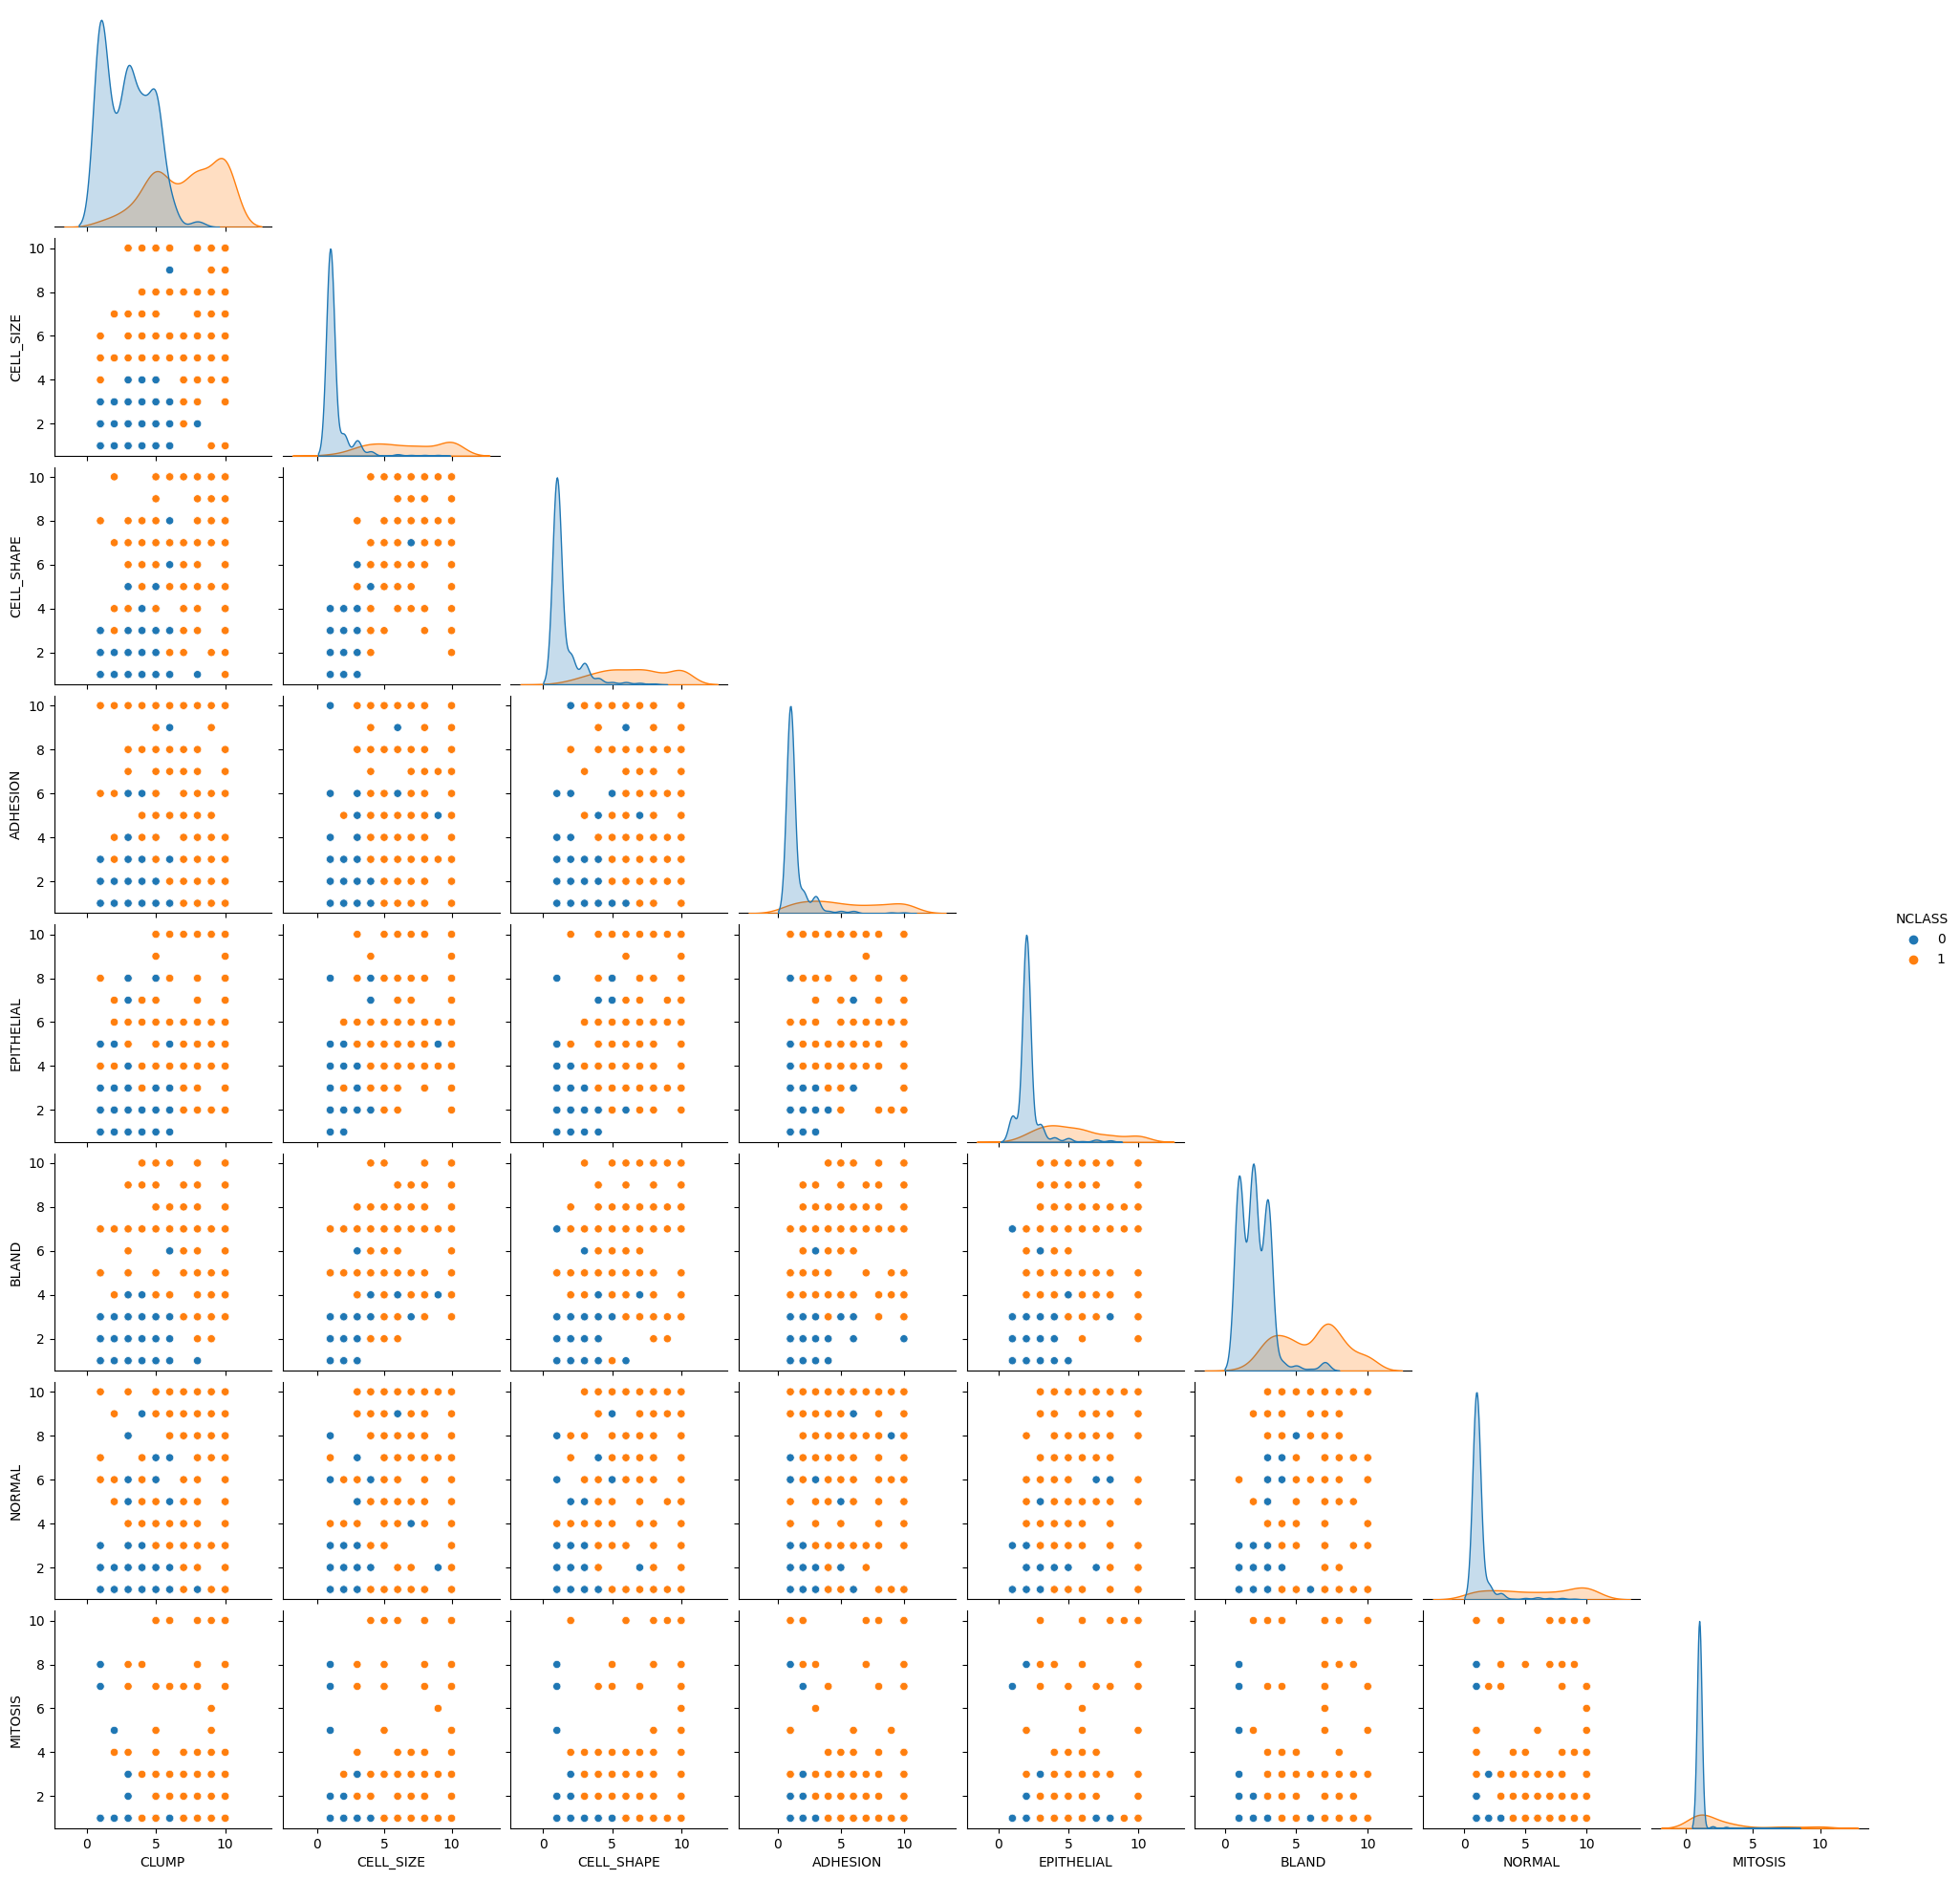

In [ ]:
# Exploratory Data Analysis for train data
# distribution of target variable with respect to features shown on the diagonal
sns.pairplot(data=train_data, hue='NCLASS', corner=True)

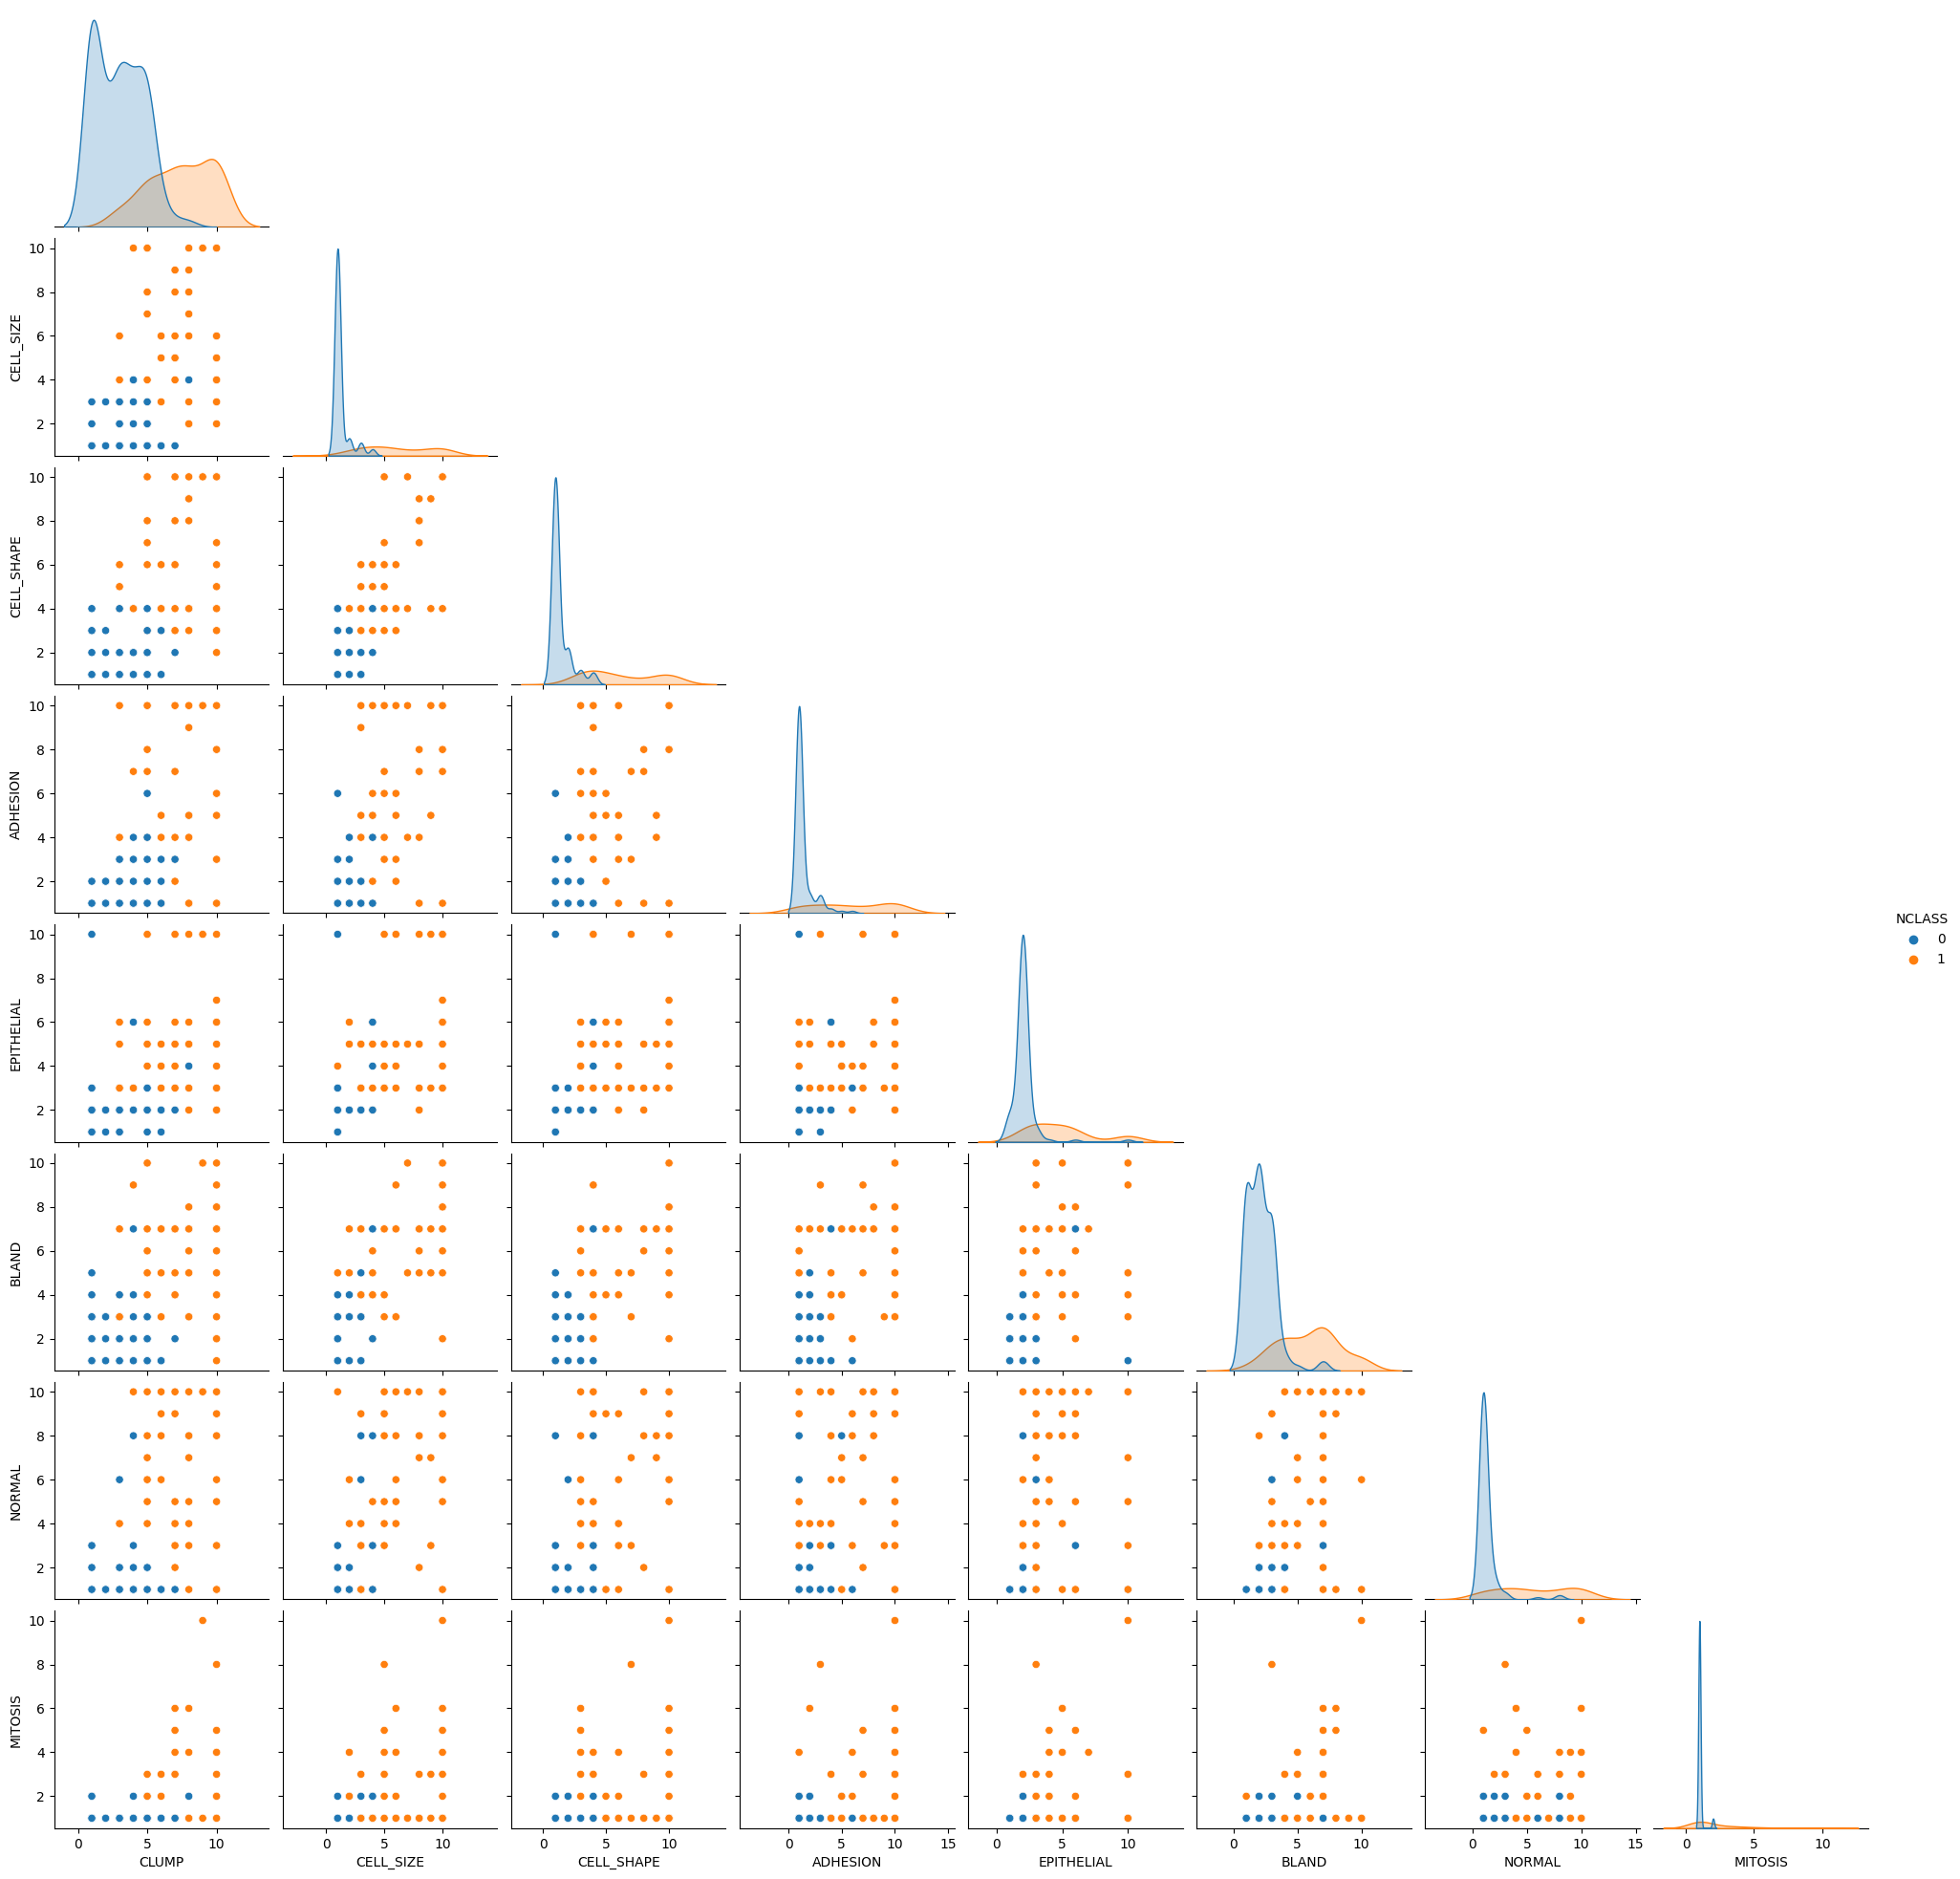

In [ ]:
# Exploratory Data Analysis for test data
# distribution of target variable with respect to features shown on the diagonal
sns.pairplot(data=test_data, hue='NCLASS', corner=True)

In [6]:
# define the features and target
x_train = train_data.drop('NCLASS', axis=1)
y_train = train_data['NCLASS']
x_test = test_data.drop('NCLASS', axis=1)
y_test = test_data['NCLASS']

In [7]:
# check blank values
# presence identified when we tried using standardscaler and got an error
for col in x_train.columns:
  print(col, len(x_train[x_train[col]==' ']))

CLUMP 0
CELL_SIZE 0
CELL_SHAPE 0
ADHESION 0
EPITHELIAL 0
BARE 13
BLAND 0
NORMAL 0
MITOSIS 0


In [8]:
x_train[x_train['BARE']==' ']

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS
22,8,4,5,1,2,,7,3,1
37,6,6,6,9,6,,7,8,1
114,1,1,1,1,1,,2,1,1
119,1,1,3,1,2,,2,1,1
129,1,1,2,1,3,,1,1,1
134,5,1,1,1,2,,3,1,1
186,3,1,4,1,2,,3,1,1
219,3,1,3,1,2,,2,1,1
231,1,1,1,1,2,,2,1,1
234,5,4,3,1,2,,2,3,1


In [9]:
x_test[x_test['BARE']==' '].index

Int64Index([50, 61, 153], dtype='int64')

In [10]:
# replace blank values with NaN
x_test.loc[x_test[x_test['BARE']==' '].index, 'BARE'] = np.nan
x_train.loc[x_train[x_train['BARE']==' '].index, 'BARE'] = np.nan
x_train['BARE'].isna().sum(), x_test['BARE'].isna().sum()

(13, 3)

In [11]:
from sklearn.impute import KNNImputer

# impute missing values (originally blanks) using KNN and 3 neighbor values
imputer = KNNImputer(n_neighbors=3)
imputed_x_train = imputer.fit_transform(x_train)
imputed_x_test = imputer.fit_transform(x_test)
x_train = pd.DataFrame(imputed_x_train, columns=x_train.columns)
x_test = pd.DataFrame(imputed_x_test, columns=x_test.columns)
x_train.isna().sum(), x_test.isna().sum()

(CLUMP         0
 CELL_SIZE     0
 CELL_SHAPE    0
 ADHESION      0
 EPITHELIAL    0
 BARE          0
 BLAND         0
 NORMAL        0
 MITOSIS       0
 dtype: int64,
 CLUMP         0
 CELL_SIZE     0
 CELL_SHAPE    0
 ADHESION      0
 EPITHELIAL    0
 BARE          0
 BLAND         0
 NORMAL        0
 MITOSIS       0
 dtype: int64)

In [12]:
x_train.head(), x_test.head()

(   CLUMP  CELL_SIZE  CELL_SHAPE  ADHESION  EPITHELIAL  BARE  BLAND  NORMAL  \
 0    5.0        1.0         1.0       1.0         2.0   1.0    3.0     1.0   
 1    5.0        4.0         4.0       5.0         7.0  10.0    3.0     2.0   
 2    3.0        1.0         1.0       1.0         2.0   2.0    3.0     1.0   
 3    6.0        8.0         8.0       1.0         3.0   4.0    3.0     7.0   
 4    4.0        1.0         1.0       3.0         2.0   1.0    3.0     1.0   
 
    MITOSIS  
 0      1.0  
 1      1.0  
 2      1.0  
 3      1.0  
 4      1.0  ,
    CLUMP  CELL_SIZE  CELL_SHAPE  ADHESION  EPITHELIAL  BARE  BLAND  NORMAL  \
 0    7.0        4.0         6.0       4.0         6.0   1.0    4.0     3.0   
 1    5.0        2.0         3.0       4.0         2.0   7.0    3.0     6.0   
 2   10.0       10.0        10.0       8.0         6.0   1.0    8.0     9.0   
 3   10.0        4.0         3.0       1.0         3.0   3.0    6.0     5.0   
 4    1.0        1.0         1.0       1.0  

In [13]:
from sklearn.preprocessing import StandardScaler

# standardize the data
scaler = StandardScaler()

# fit the scaler on the training data and transform both the training and test data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# convert the scaled arrays to dataFrame
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

x_train_scaled.head()

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS
0,0.205910,-0.718189,-0.761533,-0.639958,-0.574213,-0.711623,-0.192175,-0.617874,-0.35236
1,0.205910,0.248278,0.234702,0.783063,1.655578,1.756802,-0.192175,-0.294023,-0.35236
2,-0.505414,-0.718189,-0.761533,-0.639958,-0.574213,-0.437353,-0.192175,-0.617874,-0.35236
3,0.561572,1.536900,1.563016,-0.639958,-0.128255,0.111186,-0.192175,1.325233,-0.35236
4,-0.149752,-0.718189,-0.761533,0.071552,-0.574213,-0.711623,-0.192175,-0.617874,-0.35236


In [14]:
# check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
[print(x_train_scaled.columns[i], variance_inflation_factor(x_train_scaled.values, i)) for i in range(len(x_train_scaled.columns))]

CLUMP 1.9253521561546998
CELL_SIZE 7.184413435648257
CELL_SHAPE 6.729304692846938
ADHESION 2.380232017377813
EPITHELIAL 2.7886364774641526
BARE 2.510865780440009
BLAND 2.756663174809749
NORMAL 2.4494826149580375
MITOSIS 1.4498899624361967


[None, None, None, None, None, None, None, None, None]

In [ ]:
# based on the VIF values, we can see that the CELL_SIZE and CELL_SHAPE have high multicollinearity
# before deciding to drop one of these variables, we will look at the statistical significance of variables for the full model

In [15]:
######## BASIC LOGISTIC REGRESSION MODEL

# build the model
model = sm.Logit(y_train, x_train_scaled).fit()

# print model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.099754
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 NCLASS   No. Observations:                  532
Model:                          Logit   Df Residuals:                      523
Method:                           MLE   Df Model:                            8
Date:                Sun, 03 Dec 2023   Pseudo R-squ.:                  0.8461
Time:                        22:51:49   Log-Likelihood:                -53.069
converged:                       True   LL-Null:                       -344.93
Covariance Type:            nonrobust   LLR p-value:                7.352e-121
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CLUMP          1.2183      0.447      2.723      0.006       0.341       2.095
CELL_SIZE      0.4604      0.

In [16]:
# check model classification metrics
mprobs = model.predict(x_test_scaled)
mpred = [int(i) for i in mprobs >= 0.5]
print(classification_report(y_test, mpred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.96      0.96      0.96        54

    accuracy                           0.98       167
   macro avg       0.97      0.97      0.97       167
weighted avg       0.98      0.98      0.98       167



<Axes: ylabel='Count'>

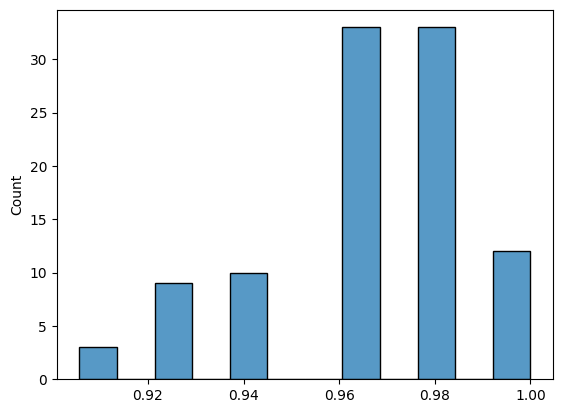

In [17]:
# perform 10-fold cross-validation on a basic logistic regression model

cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=123)
acc_scores = cross_val_score(LogisticRegression(), x_train_scaled, y_train, scoring='accuracy', cv=cross_val) # get accuracies
rc_scores = cross_val_score(LogisticRegression(), x_train_scaled, y_train, scoring='recall', cv=cross_val) # get recalls

# visualize distribution of cross-validation accuracies
sns.histplot(x=acc_scores)

<Axes: ylabel='Count'>

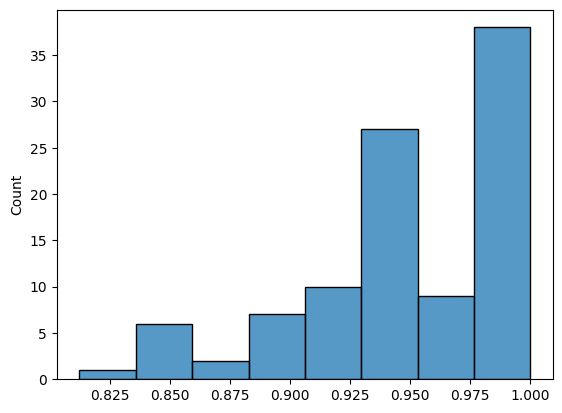

In [18]:
# visualize distribution of cross-validation recalls
sns.histplot(x=rc_scores)

In [19]:
x_train_scaled.columns

Index(['CLUMP', 'CELL_SIZE', 'CELL_SHAPE', 'ADHESION', 'EPITHELIAL', 'BARE',
       'BLAND', 'NORMAL', 'MITOSIS'],
      dtype='object')

In [20]:
!pip install mlxtend
from mlxtend.evaluate import bias_variance_decomp

Text(0, 0.5, 'Bias')

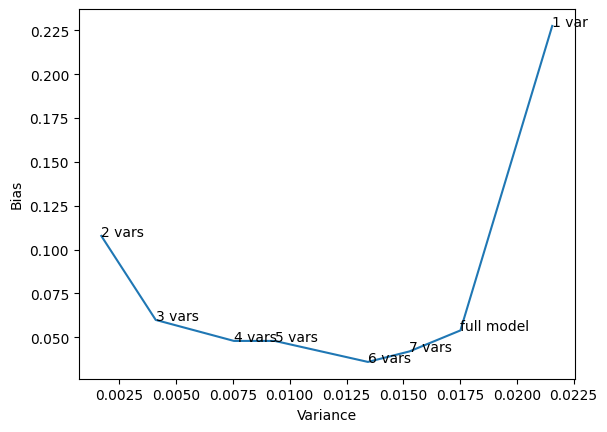

In [21]:
# both of the variables with high multicollinearity do not seem to be statistically significant in the model
# now, the question becomes - how many of the variables should we keep in the model
# such that we get an optimal bias-variance tradeoff?
# we will look at the bias-variance tradeoff graph to examine this

# calculate and plot the bias-variance tradeoff for subset models
bias = []
variance = []
loss = []
column_lists = [['CLUMP', 'CELL_SIZE', 'CELL_SHAPE', 'ADHESION', 'BARE', 'BLAND', 'NORMAL', 'MITOSIS'],\
                ['CLUMP', 'CELL_SIZE', 'CELL_SHAPE', 'ADHESION', 'BARE', 'BLAND', 'MITOSIS'],\
                ['CLUMP', 'CELL_SHAPE', 'ADHESION', 'BARE', 'BLAND', 'MITOSIS'],\
                ['CLUMP', 'ADHESION', 'BARE', 'BLAND', 'MITOSIS'],\
                ['CLUMP', 'BARE', 'BLAND', 'MITOSIS'],\
                ['BARE', 'BLAND', 'MITOSIS'],\
                ['BLAND', 'MITOSIS'],\
                ['MITOSIS']]

for i in column_lists:
  l, b, v = bias_variance_decomp(LogisticRegression(), x_train_scaled.loc[:, i].values, y_train.values, x_test_scaled.loc[:, i].values, y_test.values, loss='0-1_loss', random_seed=123)
  bias.append(b)
  variance.append(v)
  loss.append(l)

# plot the bias-variance tradeoff graph
labels = ['full model', '7 vars', '6 vars', '5 vars', '4 vars', '3 vars', '2 vars', '1 var']
fig, ax = plt.subplots()
sns.lineplot(x=variance, y=bias, ax=ax)
for i in range(len(bias)):
  plt.text(x=variance[i], y=bias[i], s=labels[i])
plt.xlabel("Variance")
plt.ylabel("Bias")


In [22]:
# statistically significant variables from model summary appear to be
# CLUMP, BARE, BLAND and MITOSIS based on p-values < 0.05
# possibly ADHESION as well, since its p-value is only slightly higher than 0.05
# combining this information with the bias-variance trade-off graph,
# we select our subset model to include 'CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION'

# new subset model with statistically significant variables
model = sm.Logit(y_train, x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']]).fit()

# print model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.106653
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 NCLASS   No. Observations:                  532
Model:                          Logit   Df Residuals:                      527
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Dec 2023   Pseudo R-squ.:                  0.8355
Time:                        22:57:08   Log-Likelihood:                -56.739
converged:                       True   LL-Null:                       -344.93
Covariance Type:            nonrobust   LLR p-value:                1.994e-123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CLUMP          1.7867      0.392      4.556      0.000       1.018       2.555
BARE           1.6537      0.

In [23]:
# we get a less complex model, at the cost of slightly lower pseudo R-squared
# and slightly lower log-likelihood
# however, given the decrease in model complexity, this is acceptable
# as long as recall is not affected significantly

# check classification metrics for the subset model
mprobs = model.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])
mpred = [int(i) for i in mprobs >= 0.5]
print(classification_report(y_test, mpred))
print(accuracy_score(y_test, mpred))
print(recall_score(y_test, mpred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       113
           1       0.96      0.96      0.96        54

    accuracy                           0.98       167
   macro avg       0.97      0.97      0.97       167
weighted avg       0.98      0.98      0.98       167

0.9760479041916168
0.9629629629629629


In [ ]:
# both accuracy and recall for positive class remain unaffected using a subset model
# based on this, the slightly lower log-likelihood is acceptable
# we now have a base model, which we can use to compare with regularized models

In [24]:
######## RIDGE CROSS-VALIDATED CLASSIFIER USING KNN IMPUTATION

# define alpha values
alphas = np.logspace(-4, 4, 100)

# initialize RidgeCV with the alpha values and Leave-One-Out cross-validation
best_ridge_cv = RidgeClassifierCV(alphas=alphas, store_cv_values = True)

# fit the model
best_ridge_cv.fit(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_train)

# get the best alpha
best_alpha_ridge = best_ridge_cv.alpha_

# evaluate the model with the best alpha value on the test data
best_y_pred_ridge = best_ridge_cv.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])
print(classification_report(y_test, best_y_pred_ridge))
rcv_recall = recall_score(y_test, best_y_pred_ridge)
rcv_acc = accuracy_score(y_test, best_y_pred_ridge)
print(rcv_recall, rcv_acc)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       113
           1       0.96      0.87      0.91        54

    accuracy                           0.95       167
   macro avg       0.95      0.93      0.94       167
weighted avg       0.95      0.95      0.95       167

0.8703703703703703 0.9461077844311377


In [ ]:
# using Ridge Classifier results in worse recall for the positive class
# given the problem, we do not want to sacrifice recall for the positive class

In [25]:
# display coefficient values and intercept value
print(pd.Series(best_ridge_cv.coef_[0], index=x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']].columns))
print(best_ridge_cv.intercept_)

CLUMP       0.242056
BARE        0.368147
BLAND       0.241590
MITOSIS     0.076174
ADHESION    0.111983
dtype: float64
[-0.29699248]


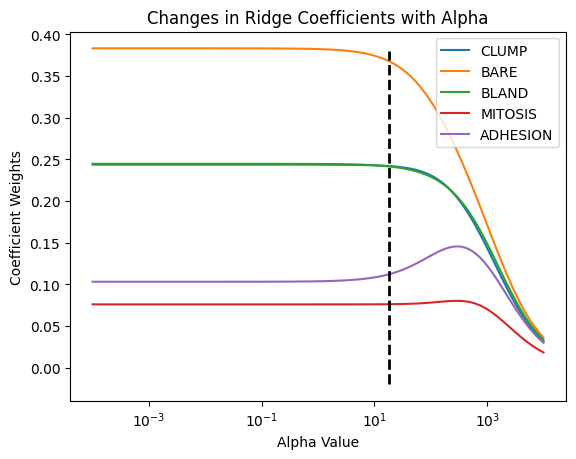

In [26]:
coefs = []
recall_scores = []
acc_scores = []

# get coefficients, recall scores and accuracies for different alpha values
for a in alphas:
    ridge_cv = RidgeClassifierCV(alphas=[a],store_cv_values=True).fit(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_train)
    coefs.append(ridge_cv.coef_[0])
    y_pred_ridge = ridge_cv.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])
    recall = recall_score(y_test, y_pred_ridge)
    recall_scores.append(recall)
    acc = accuracy_score(y_test, y_pred_ridge)
    acc_scores.append(acc)

coefs = np.array(coefs)
recall_scores = np.array(recall_scores)
acc_scores = np.array(acc_scores)

# plot coefficient value changes with changing alpha values
# check where the best alpha value from RidgeCV lies on the graph
plt.semilogx(alphas,coefs)
plt.vlines(x=best_alpha_ridge, colors='black', ymin=-0.02, ymax=0.38, ls='--', lw=2)
plt.title('Changes in Ridge Coefficients with Alpha')
plt.xlabel('Alpha Value')
plt.ylabel('Coefficient Weights')
plt.legend(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']].keys())

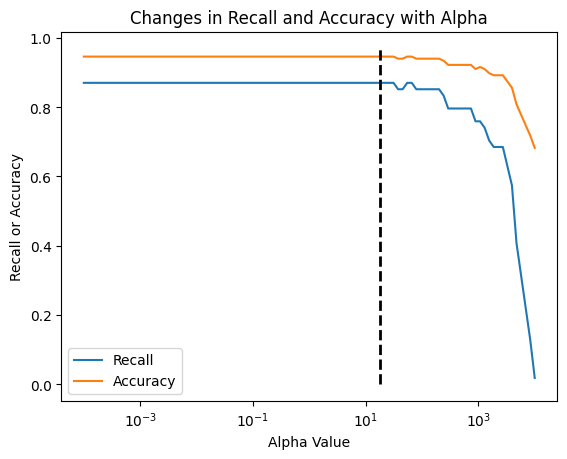

In [27]:
# plot changes in recall and accuracy with changing alpha values
# check where the best alpha value from RidgeCV lies on the graph
plt.semilogx(alphas,recall_scores)
plt.semilogx(alphas,acc_scores)
plt.vlines(x=best_alpha_ridge, colors='black', ymin=0, ymax=0.97, ls='--', lw=2)
plt.title('Changes in Recall and Accuracy with Alpha')
plt.xlabel('Alpha Value')
plt.ylabel('Recall or Accuracy')
plt.legend(['Recall', 'Accuracy'])

In [ ]:
# using a Ridge Classifier does not provide better results, at least for the 0.5 classification threshold
# we will now try a logistic model with l1 penalty which is the penalty term for LASSO

In [28]:
####### LOGISTIC REGRESSION WITH L1 PENALTY (LASSO)

# full logistic model with L1 penalty
best_logisticlasso_cv = LogisticRegressionCV(Cs=1/alphas, penalty='l1', solver='saga', cv=10, max_iter=10000)

# Fit the model
best_logisticlasso_cv.fit(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_train)

# get the best alpha
best_alpha_lasso = best_logisticlasso_cv.C_

# Evaluate the model with the best alpha value on the test data
y_pred_logitl1 = best_logisticlasso_cv.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])
print(classification_report(y_test, y_pred_logitl1))
lcvl1_recall = recall_score(y_test, y_pred_logitl1)
lcvl1_acc = accuracy_score(y_test, y_pred_logitl1)
print(lcvl1_recall, lcvl1_acc)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       113
           1       0.96      0.89      0.92        54

    accuracy                           0.95       167
   macro avg       0.95      0.94      0.94       167
weighted avg       0.95      0.95      0.95       167

0.8888888888888888 0.9520958083832335


In [ ]:
# this model also results in worse recall for the positive class

In [29]:
# display coefficient values and intercept value
print(pd.Series(best_logisticlasso_cv.coef_[0], index=x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']].columns))
print(best_logisticlasso_cv.intercept_)

CLUMP       1.641980
BARE        1.479512
BLAND       1.572512
MITOSIS     0.919087
ADHESION    0.681869
dtype: float64
[-1.11614748]


In [ ]:
# the l1 penalty does not really help with controlling coefficient values either
# based on observed recalls and accuracies for a subset model, we will focus on
# the simple logistic regression model. However, before we finalize a model,
# we will look at classification results over varying thresholds using AUC and ROC-Curve

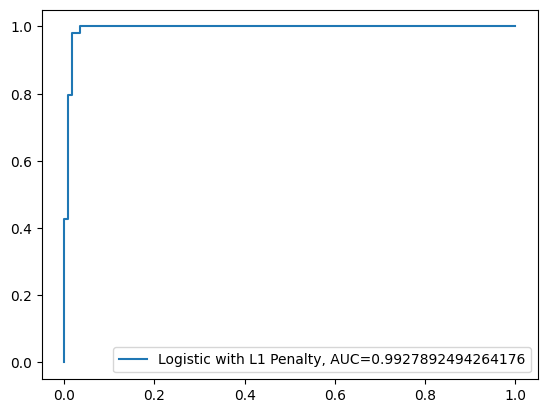

In [30]:
# get prediction probabilities for logistic model with L1 penalty
y_pred_proba = best_logisticlasso_cv.predict_proba(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])[::,1]

# get false positive rates and true positive rates
# calculate AUC - area under the curve
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# plot ROC curve
# this shows how well the model predicts comprehensively at
# varied classification thresholds
plt.plot(fpr,tpr,label="Logistic with L1 Penalty, AUC="+str(auc))
plt.plot
plt.legend(loc=4)
plt.show()

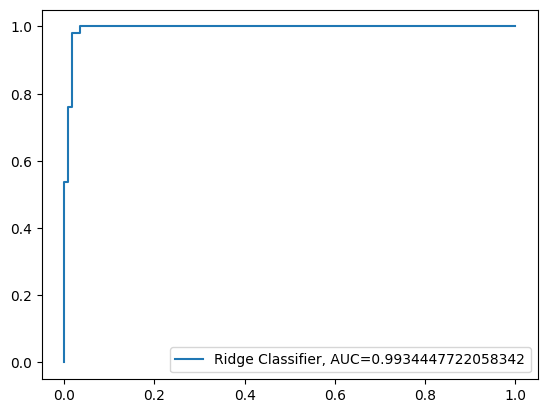

In [31]:
# AUC and ROC-Curve for Ridge Classifier
y_pred_proba = best_ridge_cv.decision_function(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])

# get false positive rates and true positive rates
# calculate AUC - area under the curve
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# plot ROC curve
# this shows how well the model predicts comprehensively at
# varied classification thresholds
plt.plot(fpr,tpr,label="Ridge Classifier, AUC="+str(auc))
plt.plot
plt.legend(loc=4)
plt.show()

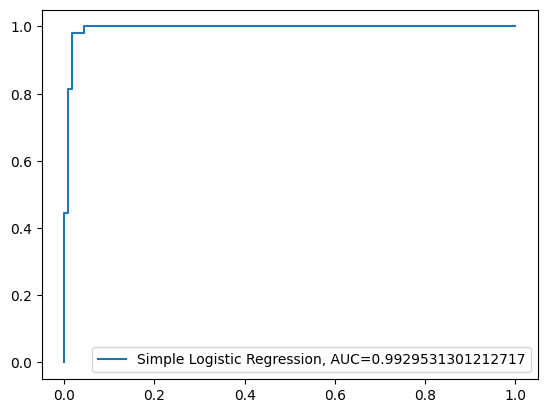

In [32]:
# AUC and ROC-Curve for simple Logistic Regression model
y_pred_proba = model.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])

# get false positive rates and true positive rates
# calculate AUC - area under the curve
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# plot ROC curve
# this shows how well the model predicts comprehensively at
# varied classification thresholds
plt.plot(fpr,tpr,label="Simple Logistic Regression, AUC="+str(auc))
plt.plot
plt.legend(loc=4)
plt.show()

In [33]:
# we get comparable AUC scores and ROC-Curves. Hence, for the final model, we
# are choosing the simple Logistic Regression model on a subset data that
# includes only the statistically significant variables from the full model

# get confidence intervals for the model coefficients
# get exponential values for interpretation
plot_df = pd.DataFrame(np.exp(model.conf_int()))
plot_df['betas'] = np.exp(model.params)
plot_df = plot_df.reset_index()
plot_df = plot_df.rename(columns={0: 'lower', 1: 'upper', 'index': 'variables'})
plot_df

,variables,lower,upper,betas
0,CLUMP,2.767690,12.875911,5.969634
1,BARE,2.576676,10.599665,5.226079
2,BLAND,2.807046,14.849776,6.456315
3,MITOSIS,2.762518,12.960878,5.983700
4,ADHESION,1.446494,6.141068,2.980439


In [34]:
!pip install forestplot
import forestplot as fp

  Attempting uninstall: matplotlib-inline
    Found existing installation: matplotlib-inline 0.1.6
    Uninstalling matplotlib-inline-0.1.6:
      Successfully uninstalled matplotlib-inline-0.1.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


<Figure size 640x480 with 0 Axes>

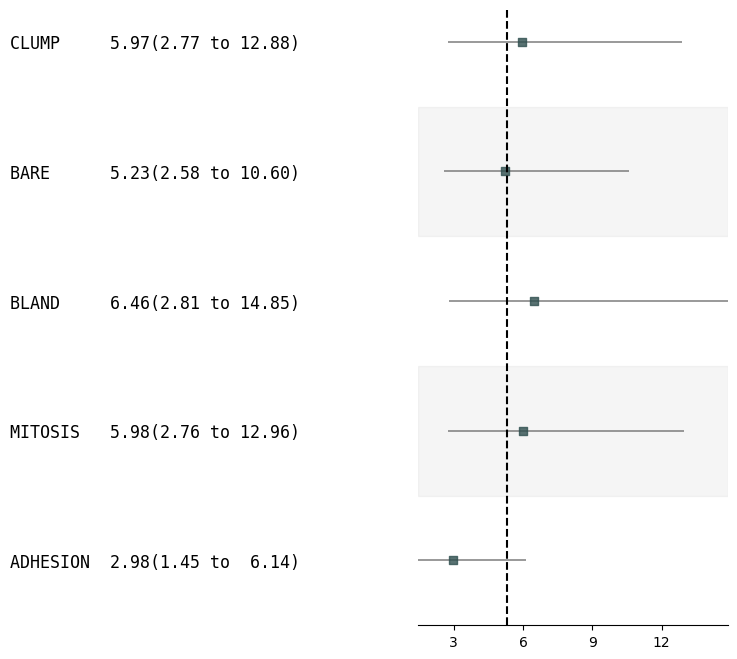

In [35]:
# forest plot to show distributions of the exponential values of coefficients
fig = plt.figure()
fig = fp.forestplot(plot_df, estimate='betas', varlabel='variables', ll='lower', hl='upper', color_alt_rows=True)
fig = plt.axvline(x=np.mean(plot_df['betas']), linestyle='--', color='black')

Text(0, 0.5, 'exp(Beta)')

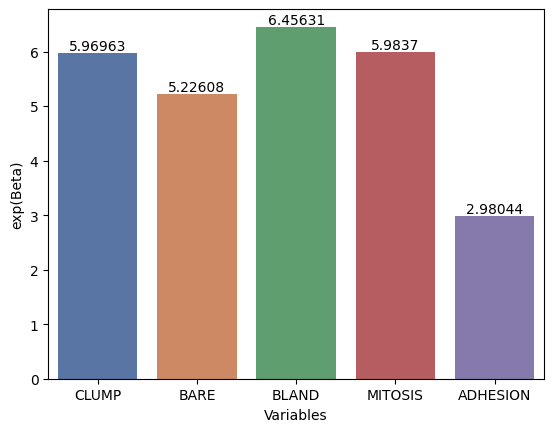

In [36]:
# bar plot
fig, ax = plt.subplots()
sns.barplot(x='variables', y='betas', data=plot_df, palette='deep', ax = ax)
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xlabel('Variables')
ax.set_ylabel('exp(Beta)')

Text(0, 0.5, 'Model Prediction Probaility')

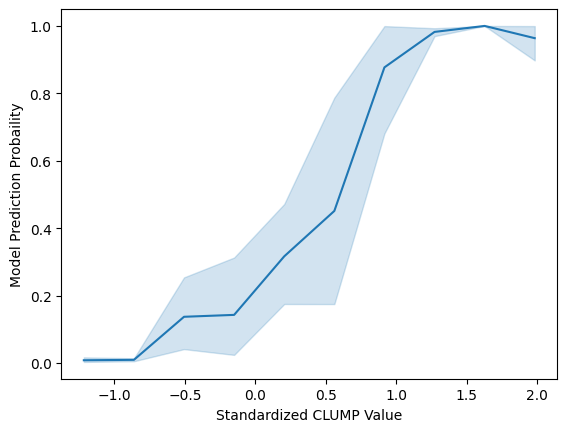

In [37]:
# model prediction curves
fig, ax = plt.subplots()
sns.lineplot(x=x_test_scaled['CLUMP'], y=y_pred_proba, ax = ax)
#sns.lineplot(x=x_test_scaled['BLAND'], y=y_pred_proba, ax = ax)
#sns.lineplot(x=x_test_scaled['BARE'], y=y_pred_proba, ax = ax)
plt.xlabel("Standardized CLUMP Value")
plt.ylabel("Model Prediction Probaility")

<Axes: xlabel='BARE'>

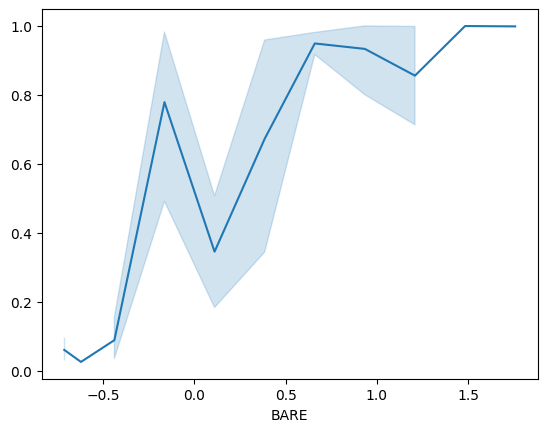

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_test_scaled['BARE'], y=y_pred_proba, ax = ax)

<Axes: xlabel='BLAND'>

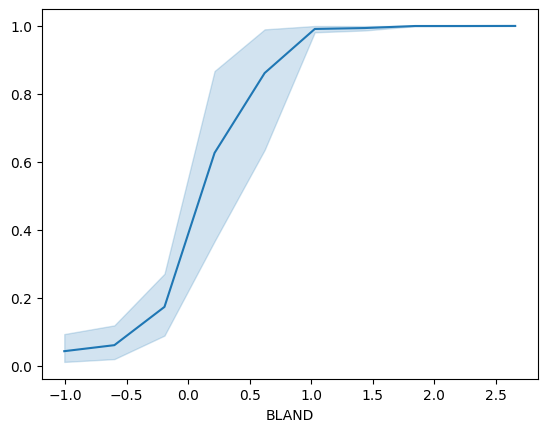

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_test_scaled['BLAND'], y=y_pred_proba, ax = ax)

<Axes: xlabel='MITOSIS'>

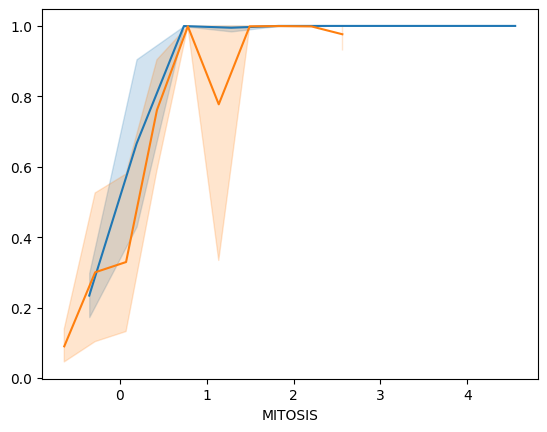

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_test_scaled['MITOSIS'], y=y_pred_proba, ax = ax)
sns.lineplot(x=x_test_scaled['ADHESION'], y=y_pred_proba, ax = ax)

<Axes: xlabel='ADHESION'>

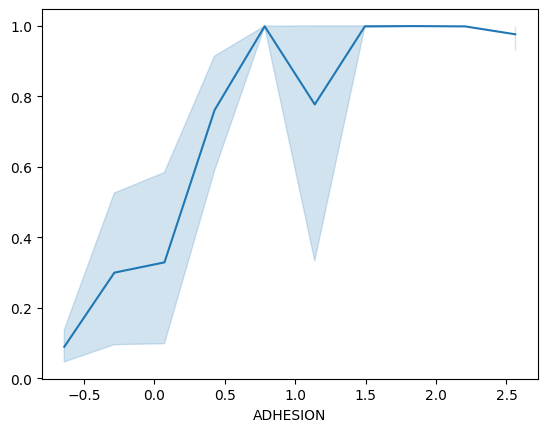

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_test_scaled['ADHESION'], y=y_pred_proba, ax = ax)

In [138]:
# Linear SVC

# function to print classification results taken from class example code
def test_network(clf, X_test, y_test):
  pred = clf.predict(X_test)
  clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
  print("Test Result:\n================================================")
  print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{clf_report}")
  print("_______________________________________________")
  print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


# Linear SVC for full model
linear_SVM = LinearSVC(loss='hinge', dual=True, class_weight='balanced', random_state=123)
linear_SVM.fit(x_train_scaled, y_train)
test_network(linear_SVM, x_test_scaled, y_test)

Test Result:
Accuracy Score: 97.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.982301   0.962963  0.976048    0.972632      0.976048
recall       0.982301   0.962963  0.976048    0.972632      0.976048
f1-score     0.982301   0.962963  0.976048    0.972632      0.976048
support    113.000000  54.000000  0.976048  167.000000    167.000000
_______________________________________________
Confusion Matrix: 
 [[111   2]
 [  2  52]]



In [139]:
# Linear SVC for subset model based on prior observed important variables
linear_SVM2 = LinearSVC(loss='hinge', dual=True, class_weight='balanced', random_state=123)
linear_SVM2.fit(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_train)
test_network(linear_SVM2, x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_test)

Test Result:
Accuracy Score: 98.20%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.991071   0.963636  0.982036    0.977354      0.982200
recall       0.982301   0.981481  0.982036    0.981891      0.982036
f1-score     0.986667   0.972477  0.982036    0.979572      0.982078
support    113.000000  54.000000  0.982036  167.000000    167.000000
_______________________________________________
Confusion Matrix: 
 [[111   2]
 [  1  53]]



In [140]:
# RBF kernel SVM for full model
gammas = [1e-3, 1e-2, 1e-1]
for gamma in gammas:
    svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=gamma, class_weight='balanced', random_state=123))
    svm.fit(x_train_scaled, y_train)
    print(f'gamma: {gamma}')
    test_network(svm, x_test_scaled, y_test)

gamma: 0.001
Test Result:
Accuracy Score: 97.60%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.982301   0.962963  0.976048    0.972632      0.976048
recall       0.982301   0.962963  0.976048    0.972632      0.976048
f1-score     0.982301   0.962963  0.976048    0.972632      0.976048
support    113.000000  54.000000  0.976048  167.000000    167.000000
_______________________________________________
Confusion Matrix: 
 [[111   2]
 [  2  52]]

gamma: 0.01
Test Result:
Accuracy Score: 98.20%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.991071   0.963636  0.982036    0.977354      0.982200
recall       0.982301   0.981481  0.982036    0.981891      0.982036
f1-score     0.986667   0.972477  0.982036    0.979572      0.982078
support    113.000000  54.000000  0.982036  167.

In [141]:
# RBF kernel SVM for subset model
gammas = [1e-3, 1e-2, 1e-1]
for gamma in gammas:
    svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=gamma, class_weight='balanced', random_state=123))
    svm.fit(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_train)
    print(f'gamma: {gamma}')
    test_network(svm, x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_test)

gamma: 0.001
Test Result:
Accuracy Score: 95.81%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.956897   0.960784  0.958084    0.958840      0.958154
recall       0.982301   0.907407  0.958084    0.944854      0.958084
f1-score     0.969432   0.933333  0.958084    0.951383      0.957760
support    113.000000  54.000000  0.958084  167.000000    167.000000
_______________________________________________
Confusion Matrix: 
 [[111   2]
 [  5  49]]

gamma: 0.01
Test Result:
Accuracy Score: 96.41%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.965217   0.961538  0.964072    0.963378      0.964028
recall       0.982301   0.925926  0.964072    0.954113      0.964072
f1-score     0.973684   0.943396  0.964072    0.958540      0.963890
support    113.000000  54.000000  0.964072  167.

In [142]:
# based on the classification results on the test data, we can see that we get very similar results
# using full model and the subset model. However, since we are able to reduce model complexity
# without affecting the model performance too much (and in some cases, we get improved performance),
# we will focus on parameter tuning for the subset model.

# define parameters values to test for best result
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear'], 'class_weight': ['balanced']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'], 'class_weight': ['balanced']},
 ]

svc = SVC()
# 10-fold cross-validated grid search
clf = GridSearchCV(svc, param_grid, cv=10)
clf.fit(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_train)
dec_func = clf.decision_function(x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])
test_network(clf, x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']], y_test)

Test Result:
Accuracy Score: 97.01%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990909   0.929825   0.97006    0.960367      0.971157
recall       0.964602   0.981481   0.97006    0.973042      0.970060
f1-score     0.977578   0.954955   0.97006    0.966267      0.970263
support    113.000000  54.000000   0.97006  167.000000    167.000000
_______________________________________________
Confusion Matrix: 
 [[109   4]
 [  1  53]]



In [143]:
# check the best parameters found via cross-validated grid search
clf.best_params_

{'C': 10, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}

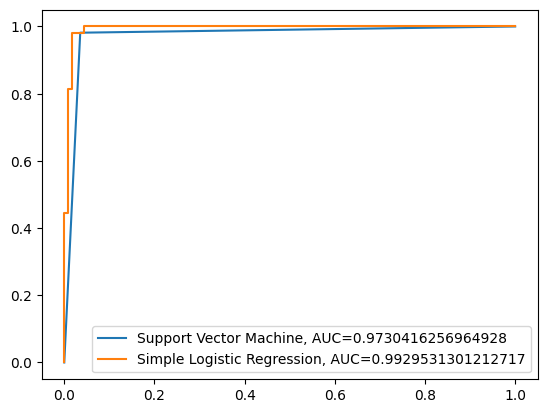

In [144]:
# AUC and ROC-Curve for best parameters SVM model
y_pred_proba = clf.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])

# get false positive rates and true positive rates
# calculate AUC - area under the curve
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# FPR, TPR for Simple Logistic model for comparison
y_pred_proba2 = model.predict(x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']])
fpr2, tpr2, _ = roc_curve(y_test,  y_pred_proba2)
auc2 = roc_auc_score(y_test, y_pred_proba2)

# plot ROC curve
# this shows how well the model predicts comprehensively at
# varied classification thresholds
plt.plot(fpr,tpr,label="Support Vector Machine, AUC="+str(auc))
plt.plot(fpr2,tpr2,label="Simple Logistic Regression, AUC="+str(auc2))
plt.legend(loc=4)
plt.show()

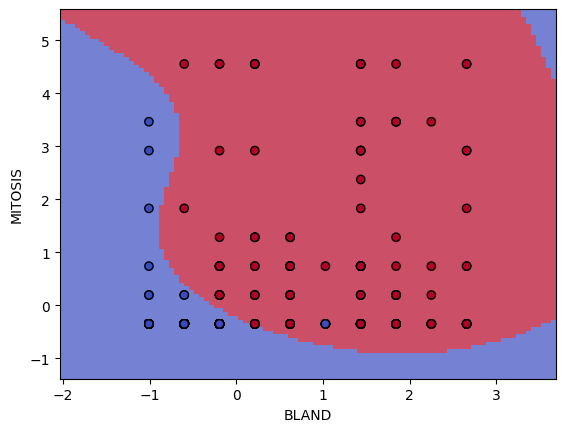

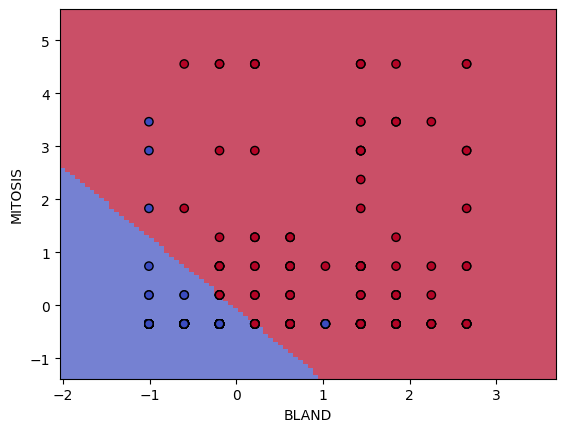

In [145]:
train_subset = x_train_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']]
test_subset = x_test_scaled.loc[:, ['CLUMP', 'BARE', 'BLAND', 'MITOSIS', 'ADHESION']]

# function to plot SVM decision boundaries for pairs of features
# need to create SVM model with just corresponding 2 features to be able to plot
def plot_decision_boundary(feature1, feature2, kernel_name):
  best_SVM = SVC(kernel=kernel_name, gamma=0.1, C=10, class_weight='balanced', random_state=123)
  best_SVM.fit(train_subset.loc[:, [feature1, feature2]], y_train)
  ax = plt.gca()
  DecisionBoundaryDisplay.from_estimator(best_SVM, train_subset.loc[:, [feature1, feature2]], \
                                         cmap=plt.cm.coolwarm, ax=ax, \
                                         response_method="predict", alpha=0.7, \
                                         plot_method="pcolormesh", shading="auto")
  plt.scatter(train_subset[feature1], train_subset[feature2], c=y_train, cmap=plt.cm.coolwarm, edgecolors="k")

# plot decision boundary between BLAND and MITOSIS
plt.figure()
plot_decision_boundary('BLAND', 'MITOSIS', 'rbf')
plt.show()
# compare to linear kernel
plt.figure()
plot_decision_boundary('BLAND', 'MITOSIS', 'linear')
plt.show()

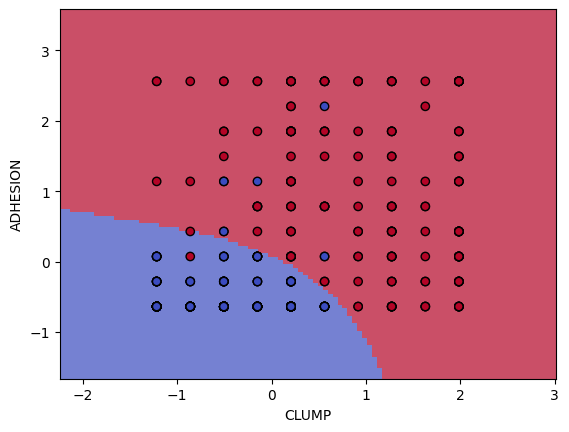

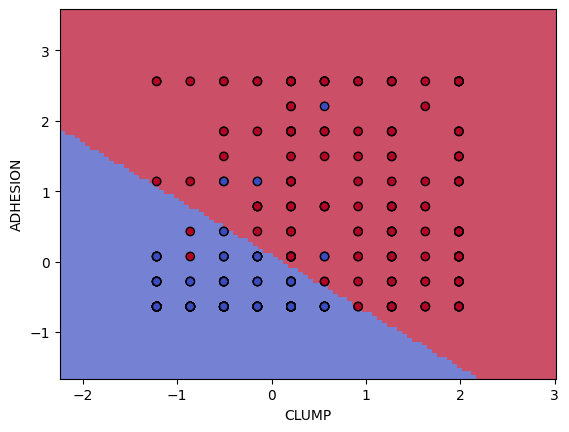

In [146]:
# plot decision boundary between CLUMP and ADHESION
plt.figure()
plot_decision_boundary('CLUMP', 'ADHESION', 'rbf')
plt.show()
# compare to linear kernel
plt.figure()
plot_decision_boundary('CLUMP', 'ADHESION', 'linear')
plt.show()

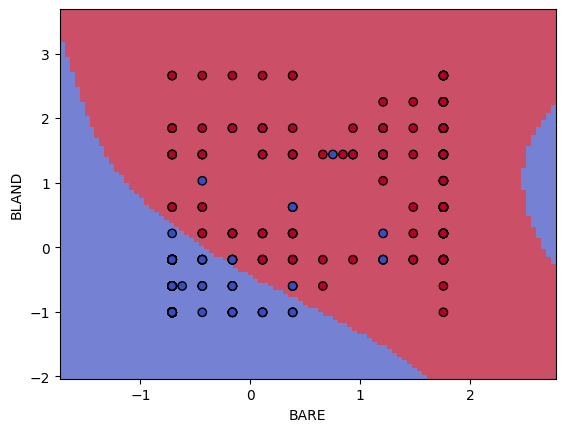

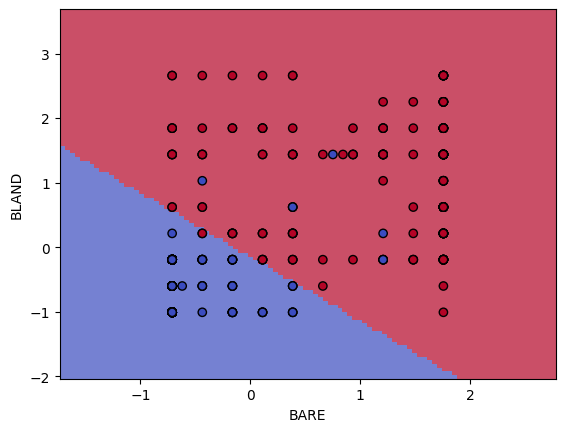

In [147]:
# plot decision boundary between BARE and BLAND
plt.figure()
plot_decision_boundary('BARE', 'BLAND', 'rbf')
plt.show()
# compare to linear kernel
plt.figure()
plot_decision_boundary('BARE', 'BLAND', 'linear')
plt.show()